In [ ]:
#
# Julia version of code adapted from
# https://github.com/rawlings-group/paresto/blob/master/examples/green_book/ABC.m
#

In [1]:
using CSV, DataFrames
using DifferentialEquations, DiffEqSensitivity
using Plots
using Optim
using FiniteDiff, ForwardDiff

In [2]:
ABC_data = CSV.read("data_sets/ABC_data.csv", DataFrame)

,t,ca,cb,cc
,Float64,Float64,Float64,Float64
1,0.0,0.957,-0.031,-0.015
2,0.263,0.557,0.33,0.044
3,0.526,0.342,0.512,0.156
4,0.789,0.224,0.499,0.31
5,1.053,0.123,0.428,0.454
6,1.316,0.079,0.396,0.556
7,1.579,0.035,0.303,0.651
8,1.842,0.029,0.287,0.658
9,2.105,0.025,0.221,0.75


In [3]:
function rates!(dc, c, p, t)
    cA = c[1]
    cB = c[2]
    cC = c[3]
    
    k1 = p[1]
    k2 = p[2]
    
    dcA = -k1 * cA
    dcB = k1 * cA - k2 * cB
    dcC = k2 * cB
    
    dc[1] = dcA
    dc[2] = dcB
    dc[3] = dcC

end

rates! (generic function with 1 method)

In [4]:
c0 = [1.0, 0.0, 0.0]
p = [2.0, 1.0]
tspan = (0.0, 5.0)
prob = ODEProblem(rates!, c0, tspan, p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 5.0)
u0: 3-element Vector{Float64}:
 1.0
 0.0
 0.0

In [5]:
sol = solve(prob, Rosenbrock23());

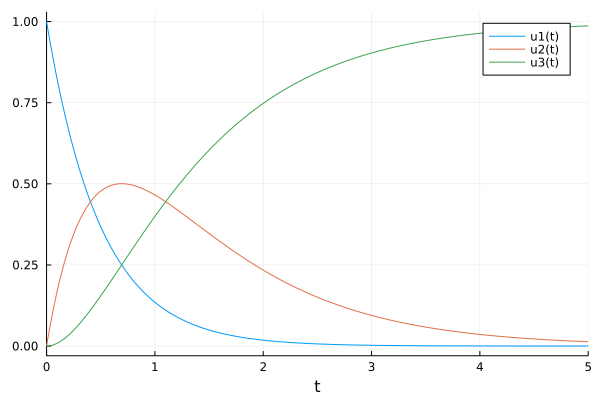

In [6]:
plot(sol)

In [7]:
function calc_SSE(p, data)
    _prob = remake(prob, p = p)
    sol = solve(_prob, Rosenbrock23())
    sse = 0.0
    for (i, t) in enumerate(data.t)
        sse = sse + (sol(t)[1] - data.ca[i])^2 + (sol(t)[2] - data.cb[i])^2 + (sol(t)[3] - data.cc[i])^2
    end
    return sse
end

calc_SSE (generic function with 1 method)

In [8]:
calc_SSE([5.0, 5.0], ABC_data)

2.7636927492809873

In [11]:
res_pe = optimize(p -> calc_SSE(p, ABC_data), [5.0, 5.0], BFGS())

 * Status: success

 * Candidate solution
    Final objective value:     2.612913e-02

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 5.76e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.85e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.26e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.40e-13 ≰ 0.0e+00
    |g(x)|                 = 9.53e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   3  (vs limit Inf)
    Iterations:    689
    f(x) calls:    2741
    ∇f(x) calls:   2741


In [12]:
res_pe.minimizer

2-element Vector{Float64}:
 2.0175094106583837
 0.993230737325196

In [13]:
_prob = remake(prob, p = p)
sol = solve(_prob, Rosenbrock23());

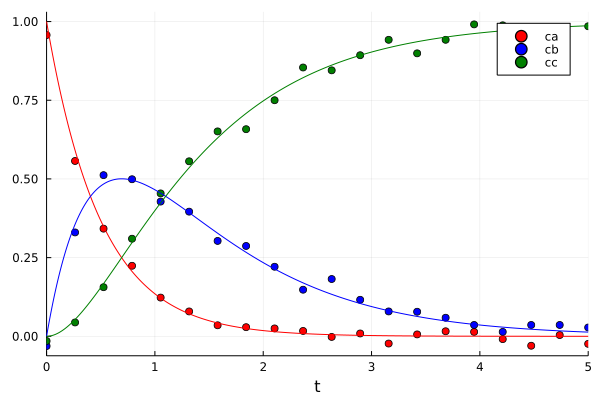

In [14]:
plot(ABC_data.t, [ABC_data.ca, ABC_data.cb, ABC_data.cc], seriestype = :scatter, color = [:red :blue :green], label = ["ca" "cb" "cc"])
plot!(sol, color = [:red :blue :green], label = ["" "" ""])

In [18]:
H_ad = ForwardDiff.hessian(p -> calc_SSE(p, ABC_data), [2.0, 1.0])

2×2 Matrix{Float64}:
 0.463788  0.516058
 0.516058  3.27101

In [19]:
H = FiniteDiff.finite_difference_hessian(p -> calc_SSE(p, ABC_data), [2.0, 1.0])

2×2 LinearAlgebra.Symmetric{Float64, Matrix{Float64}}:
 0.465589  0.516257
 0.516257  3.27146

In [20]:
n = size(ABC_data)[1] * 3
p = 2
mse = calc_SSE([2.0, 1.0], ABC_data)/(n - p)

0.000451974364001868

In [21]:
cov_est = 2 * mse * inv(H_ad)

2×2 Matrix{Float64}:
  0.00236406   -0.000372971
 -0.000372971   0.000335194